# Análise exploratória do planejamento orçamentário da Prefeitura de João Pessoa no ano de 2022

##### Fonte: [Portal da Transparência, detalhamento de despesas de 2022](https://transparencia.joaopessoa.pb.gov.br/#/despesas/despesas-detalhamento)
> - Foi escolhido o valor empenhado por representar o valor planejado.
> - Necessário aprofundamento nos valores liquidados e valores pagos

In [1]:
#Imports
%pip install pandas
%pip install plotly==5.21.0

import pandas as pd
import plotly.graph_objects as go


Note: you may need to restart the kernel to use updated packages.



### Conteúdo dos dados

In [2]:
# Leitura dos dados
pd.set_option("float_format",'{:.2f}'.format)
df = pd.read_csv(filepath_or_buffer='./data/2022.csv', sep='|', low_memory=False)
df.head(5)

,nume_empenho,ano_empenho,unidade_orcamentaria,codi_unor,favorecido,data_empenho,valor_empenhado,valor_liquidado,valor_pago,saldo_pagar
0,1,2022,UNIDADE EXECUTORA DO PROGRAMA JOAO PESSOA SUST...,710103,MJV SERVICOS DE ESCRITORIOS COMPARTILHADOS LTDA,2022-01-31,274760.50,252322.76,252322.76,0.00
1,1,2022,SECRETARIA MUNICIPAL DE CIENCIA E TECNOLOGIA-G...,270101,ALFAPRINT LOCACOES LTDA-ME,2022-01-28,1020.00,1020.00,1020.00,0.00
2,1,2022,CONTROLADORIA GERAL DO MUNICIPIO-GABINETE DO S...,320101,SECRETARIA DE FINANCAS DO MUNICIPIO (SEFIN),2022-01-28,146449.39,146449.39,107643.28,38806.11
3,1,2022,COORDENADORIA MUNICIPAL DE PROMOCAO A CIDADANI...,710104,GERALDO DE SOUZA LEITE FILHO,2022-11-22,1458.34,1458.34,1458.34,0.00
4,1,2022,DIRETORIA DE GESTAO CURRICULAR,100102,IPM-INSTITUTO DE PREVIDENCIA DO MUNICIPIO,2022-01-28,0.00,0.00,0.00,0.00


In [3]:
# Análise dos tipos disponíveis
df["data_empenho"] = pd.to_datetime(df["data_empenho"])
df["trimestre_empenho"] = df["data_empenho"].dt.quarter
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29567 entries, 0 to 29566
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   nume_empenho          29567 non-null  int64         
 1   ano_empenho           29567 non-null  int64         
 2   unidade_orcamentaria  29567 non-null  object        
 3   codi_unor             29567 non-null  int64         
 4   favorecido            29567 non-null  object        
 5   data_empenho          29567 non-null  datetime64[ns]
 6   valor_empenhado       29567 non-null  float64       
 7   valor_liquidado       29567 non-null  float64       
 8   valor_pago            29567 non-null  float64       
 9   saldo_pagar           29567 non-null  float64       
 10  trimestre_empenho     29567 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(3), object(2)
memory usage: 2.4+ MB


> - A partir desta análise prévia foi identificado a necessidade da conversão do campo `data_empenho` para o tipo `datetime64`, facilitando os possíveis cálculos a partir de datas.
> - Como o ano fiscal geralmente é dividido em trimestres, o campo `trimestre_empenho` foi adicionado sendo inferido a partir do campo `data_empenho`, onde, **1** representa o primeiro trimestre, **2** o segundo trimestre, **3** o terceiro trimestre e **4** o quarto trimestre.

#### Identificação dos dados que podem ser agrupados e dos dados que podem ser agrupadores.

> São escolhidos os dados com menor quantidade para serem agrupadores, neste caso `trimestre_empenho` e `unidade_orcamentaria`.

In [4]:
# verificação de dados únicos
valores_unicos = pd.DataFrame(map(lambda columnn:
    {
        "coluna": columnn,
        "quantidade": df[columnn].nunique(),
        "valores": df[columnn].unique()
    } ,df.columns)).sort_values("quantidade")
valores_unicos

,coluna,quantidade,valores
1,ano_empenho,1,[2022]
10,trimestre_empenho,4,"[1, 4, 2, 3]"
2,unidade_orcamentaria,46,[UNIDADE EXECUTORA DO PROGRAMA JOAO PESSOA SUS...
3,codi_unor,48,"[710103, 270101, 320101, 710104, 100102, 50301..."
5,data_empenho,265,"[2022-01-31 00:00:00, 2022-01-28 00:00:00, 202..."
9,saldo_pagar,4520,"[0.0, 38806.11, 3026.03, 13771.44, 7042.7, 667..."
0,nume_empenho,6678,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,favorecido,8219,[MJV SERVICOS DE ESCRITORIOS COMPARTILHADOS LT...
7,valor_liquidado,11613,"[252322.76, 1020.0, 146449.39, 1458.34, 0.0, 4..."
6,valor_empenhado,12058,"[274760.5, 1020.0, 146449.39, 1458.34, 0.0, 40..."


### Total do valor empenhado em 2022 pela Prefeitura de João Pessoa

In [25]:
# Gráfico tipo KPI
valor_total = df["valor_empenhado"].sum()

fig = go.Figure(go.Indicator(
    mode = "number",
    value = valor_total,
    number = {'prefix': "R$ "},
    domain = {'x': [0, 1], 'y': [0, 1]}))

fig.update_layout(paper_bgcolor = "lightgray")
fig.show()

### Lista de unidades orçamentárias

In [39]:
# Listagem
pd.DataFrame({"Unidades Orçamentárias":df["unidade_orcamentaria"].sort_values().unique()})

,Unidades Orçamentárias
0,CONTROLADORIA GERAL DO MUNICIPIO-GABINETE DO S...
1,COORDENADORIA MUNICIPAL DE PROMOCAO A CIDADANI...
2,DIRETORIA ADM FIN - COORDENADORA MUNICIPAL DE ...
3,DIRETORIA DE GESTAO CURRICULAR
4,FUNDACAO CULTURAL DE JOAO PESSOA-FUNJOPE
5,"FUNDO DE GESTAO, DESENV. E MODERNIZACAO DA PROGEM"
6,FUNDO DO TRABALHO DE JOAO PESSOA
7,FUNDO MUNICIPAL DE ASSISTENCIA SOCIAL - FMAS
8,FUNDO MUNICIPAL DE CULTURA
9,FUNDO MUNICIPAL DE DEFESA DOS DIREITOS DIFUSOS...


### Totais por unidades orçamentárias

In [49]:
# Somatório por unidade orçamentária e impácto percentual do total.
valores_unidades_orcamentarias = df[["unidade_orcamentaria","valor_empenhado"]].groupby("unidade_orcamentaria").sum()
valores_unidades_orcamentarias["%"] = valores_unidades_orcamentarias["valor_empenhado"].div(valor_total)*100
valores_unidades_orcamentarias.sort_values("valor_empenhado", ascending=False)

,valor_empenhado,%
unidade_orcamentaria,,
FUNDO MUNICIPAL DE SAUDE,996786486.27,31.63
SECRETARIA MUNICIPAL DE EDUCACAO E CULTURA-GABINETE DO SECRETARIO,731374474.81,23.21
INSTITUTO DE PREVIDENCIA DO MUNICIPIO - IPM,341984227.98,10.85
SUPERINTENDENCIA DE LIMPEZA URBANA - EMLUR,179901773.82,5.71
SECRETARIA DE INFRAESTRUTURA-GABINETE DO SECRETARIO,158154697.49,5.02
RECURSOS SOB A SUPERVISAO DA SECRETARIA DA ADMINISTRACAO,106644095.23,3.38
RECURSOS SOB A SUPERVISAO DA SECRETARIA DAS FINANCAS,100955005.15,3.20
UNIDADE EXECUTORA DO PROGRAMA JOAO PESSOA SUSTENTAVEL,60916434.82,1.93
SUPERINTENDENCIA EXECUTIVA DE MOBILIDADE URBANA DE JOAO PESSOA - SEMOB,59811353.80,1.90


### Execussão orçamentária por trimestre

#### Percentual de execussão orçamentária por trimestre

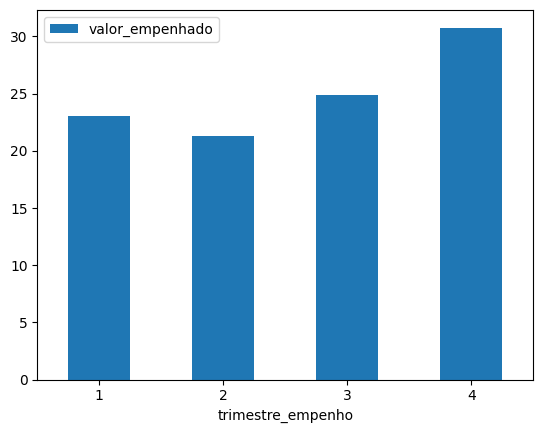

In [62]:
# Percentual do valor total por trimestre
percentual_trimestre = df[["trimestre_empenho","valor_empenhado"]].groupby(["trimestre_empenho"]).sum()
percentual_trimestre["valor_empenhado"] = percentual_trimestre["valor_empenhado"].div(valor_total)*100
axs = percentual_trimestre.plot.bar(rot=0)